In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import numpy as np

In [3]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
threshold = 0.2
suffix='dist'
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [4]:
INPUT_ROOT_DIR='/raid0/homes/aghayoor/Desktop/pure_plugs/inputs'
OUTPUT_ROOT_DIR='/raid0/homes/aghayoor/Desktop/pure_plugs/outputs'
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OUTPUT_MASK_NAME = 'pure_binary_mask_' + str(threshold) + '_' + suffix + '.nrrd'
OUTPUT_MASK = os.path.join(OUTPUT_ROOT_DIR,OUTPUT_MASK_NAME)
print(OUTPUT_MASK)

OUTPUT_Label_MASK_NAME = 'pure_LABEL_mask_' + str(threshold) + '_' + suffix + '.nrrd'
OUTPUT_Label_MASK = os.path.join(OUTPUT_ROOT_DIR,OUTPUT_Label_MASK_NAME)
print(OUTPUT_Label_MASK)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

T1fn = os.path.join(INPUT_ROOT_DIR,'t1_average_BRAINSABC.nii.gz')
T2fn = os.path.join(INPUT_ROOT_DIR,'t2_average_BRAINSABC.nii.gz')
DWIfn = os.path.join(INPUT_ROOT_DIR,'IDWI_Output.nrrd')
brain_labels_fn = os.path.join(INPUT_ROOT_DIR,'complete_brainlabels_seg.nii.gz')

/raid0/homes/aghayoor/Desktop/pure_plugs/outputs/pure_binary_mask_0.2_dist.nrrd
/raid0/homes/aghayoor/Desktop/pure_plugs/outputs/pure_LABEL_mask_0.2_dist.nrrd


In [5]:
T1_raw = sitk.ReadImage(T1fn)
T2_raw = sitk.ReadImage(T2fn)
BRAINSLabels = sitk.ReadImage(brain_labels_fn)

#------- DWI ------------
#-- either
DWI3D = sitk.ReadImage(DWIfn)
#-- OR
'''
DWI = sitk.ReadImage(DWIfn)
# crop DWI to a smaller image named DWI3D
start = [60,60,35]
size = [i/10 for i in DWI.GetSize()]
ROIFilt = sitk.RegionOfInterestImageFilter()
ROIFilt.SetIndex(start)
ROIFilt.SetSize(size)
DWI3D = ROIFilt.Execute(DWI)
sitk.WriteImage(DWI3D,'/raid0/homes/aghayoor/Desktop/pure_plugs/DWI_cropped.nrrd')
print(DWI.GetSize())
print(DWI3D.GetSize())
'''
#----------------------

purePlugsMask = sitk.Image(DWI3D.GetSize(),sitk.sitkUInt8)
purePlugsMask.CopyInformation(DWI3D)

In [6]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

In [7]:
T13D = NormalizeBetweenZeroAndOne(T1_raw)
T23D = NormalizeBetweenZeroAndOne(T2_raw)

In [8]:
statTest=sitk.StatisticsImageFilter()
statTest.Execute(T13D)
print(statTest.GetMaximum())
print(statTest.GetMinimum())
print(statTest.GetMean())
print(statTest.GetSigma())

1.0
0.0
0.230287262709
0.33375752339


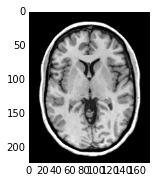

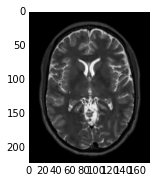

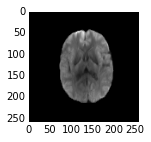

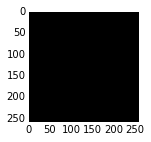

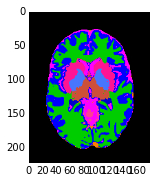

In [9]:
myshow(T13D)
myshow(T23D)
myshow(DWI3D)
myshow(purePlugsMask)
myshow(sitk.LabelToRGB(BRAINSLabels))

#print(DWI3D)
#print(purePlugsMask)

In [10]:
def MahalanobisDist(x, y):
    covariance_xy = np.cov(x,y, rowvar=0)
    inv_covariance_xy = np.linalg.inv(covariance_xy)
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i - xy_mean[0] for x_i in x])
    y_diff = np.array([y_i - xy_mean[1] for y_i in y])
    diff_xy = np.transpose([x_diff, y_diff])
    
    md = []
    for i in range(len(diff_xy)):
        md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
    return md

In [11]:
def EuclideanDistanc(x,y):
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i - xy_mean[0] for x_i in x])
    y_diff = np.array([y_i - xy_mean[1] for y_i in y])
    diff_xy = np.transpose([x_diff, y_diff])
    
    ed = []
    for i in range(len(diff_xy)):
        ed.append(np.sqrt(np.dot(np.transpose(diff_xy[i]),diff_xy[i])))
    return ed

In [12]:
def hasOutliers(x, y, threshold):
    MD = MahalanobisDist(x, y)
    MD_norm = MD/max(MD)
    ED = EuclideanDistanc(x,y)
    Dist = ED*MD_norm
    #
    #print("Mahalanobis dist: {0}".format(MD)) # <-----
    #print("Euclidian dist: {0}".format(ED)) # <-----
    #print("Weighted dist: {0}".format(Dist)) # <-----
    #
    for i in range(len(Dist)):
        if Dist[i] >= threshold:
            return True
    return False

In [88]:
def isPurePlug(idx, DWI, T1, T2, threshold, f=0):
    # high spacing (low resolution)
    hspc=np.array(DWI.GetSpacing())
    # low spacing (high resolution)
    lspc=np.array(T1.GetSpacing())

    if f>0:
      factor=f
    else:
      factor=hspc/lspc
        
    stepSize=hspc/factor

    hResSize = T1.GetSize()
    
    # continues index
    cidx=np.array([float(i) for i in idx])
    #
    #print(cidx) # <-----
    #
    isInside = True
    t1_sampleValues=[]
    t2_sampleValues=[]
    for iss in np.arange(cidx[0]-hspc[0]/2+stepSize[0]/2,cidx[0]+hspc[0]/2,stepSize[0]):
        for jss in np.arange(cidx[1]-hspc[1]/2+stepSize[1]/2,cidx[1]+hspc[1]/2,stepSize[1]):
            for kss in np.arange(cidx[2]-hspc[2]/2+stepSize[2]/2,cidx[2]+hspc[2]/2,stepSize[2]):
                cssidx=[iss, jss, kss]
                #
                #print("continus sabsample: {0}".format(cssidx)) # <-----
                #
                p = DWI.TransformContinuousIndexToPhysicalPoint(cssidx)
                #
                #print("point: {0}".format(p)) # <-----
                #
                # In ITK implementation, you may need:
                # First, check wether the physical point p is inside the buffer
                # Then, get the image value directly from point p
                newidx = T1.TransformPhysicalPointToIndex(p)
                #
                #print("newidx: {0}".format(newidx)) # <-----
                #
                if any( newidx[i] < 0 or newidx[i] >= hResSize[i] for i in range(len(newidx))):
                    isInside = False
                    #
                    #print("is not inside") # <-----
                    #
                    break
                else:
                    t1_value = T1[newidx]
                    t2_value = T2[newidx]
                    t1_sampleValues.append(t1_value)
                    t2_sampleValues.append(t2_value)
            else:
                continue
            break
        else:
            continue
        break

    ispure = False
    if isInside:
        #
        #print("sample values: ") # <-----
        #print(t1_sampleValues) # <-----
        #print(t2_sampleValues) # <-----
        #
        t1_arr = np.array(t1_sampleValues)
        t2_arr = np.array(t2_sampleValues)
        # First check to see wether the covariance matrix is zero
        # This the ideal case when all values in t1_arr are identical, and the same for t2_arr
        # In this case, surely we have a pure plug
        cov_t1t2 = np.cov(t1_arr,t2_arr)
        #
        #print("cov: {0}".format(cov_t1t2)) # <-----
        #print("det cov: {0}".format(np.linalg.det(cov_t1t2))) # <-----
        #
        if np.linalg.det(cov_t1t2) == 0: # it means that the std in at least one image is zero 
            ispure = True
            if ((np.sqrt(cov_t1t2[0][0]) >= threshold) or (np.sqrt(cov_t1t2[1][1]) >= threshold)): # However, if one image has a big varaince in plug area
                ispure = False
        # The above ideal case mostly happen in background area!
        # In reality, we should allow some variation in voxel values in the area of a pure plug.
        # Here, the "Weighted Distance Metric" is used to decide about the allowed variation.
        else:
            ispure = not(hasOutliers(t1_arr,t2_arr,threshold))
    #
    #print("Is pure: {0}".format(ispure)) # <-----
    #
    return ispure

In [89]:
dwi_size = DWI3D.GetSize()

for i in range(0,dwi_size[0]):
  for j in range(0,dwi_size[1]):
    for k in range(0,dwi_size[2]):
      idx=[i,j,k]
      if( isPurePlug(idx,DWI3D,T13D,T23D,threshold) ):
        purePlugsMask[idx] = 1
      else:
        purePlugsMask[idx] = 0

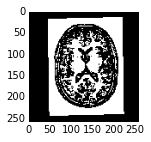

In [90]:
myshow(purePlugsMask)
sitk.WriteImage(purePlugsMask,OUTPUT_MASK)

In [91]:
# Resample purePlugMask to BABC brain label map voxel space, using default transform that is identity
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(BRAINSLabels)
resFilt.SetOutputPixelType(BRAINSLabels.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkNearestNeighbor) # Nearest neighbor interpolation
pureMask_resampled = resFilt.Execute(purePlugsMask)

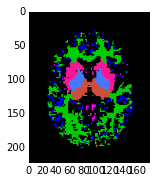

In [92]:
pure_label_mask = pureMask_resampled * BRAINSLabels

sitk.WriteImage(pure_label_mask,OUTPUT_Label_MASK)
myshow(sitk.LabelToRGB(pure_label_mask))

In [93]:
BrainlabelDic=dict(WM=1, SURFGM=2, CSF=4, VB=5, CRBLGM=11, CRBLWM=12, BASAL=19, GLOBUS=23, THALAMUS=24, HIPPOCAMPUS=25, AIR=0)
print(BrainlabelDic)

{'THALAMUS': 24, 'VB': 5, 'CRBLGM': 11, 'HIPPOCAMPUS': 25, 'GLOBUS': 23, 'SURFGM': 2, 'CSF': 4, 'AIR': 0, 'BASAL': 19, 'CRBLWM': 12, 'WM': 1}


In [94]:
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(T13D, pure_label_mask)
print('Number of lables', statFilter.GetNumberOfLabels())
print('Number of voxels for each label in the pure mask')
print('Distance threshold was: ', threshold)
print('-------------------')

for key, value in BrainlabelDic.iteritems():
    labelID = int(value)
    print(key, ' : ' , statFilter.GetCount(labelID))

Number of lables 12
Number of voxels for each label in the pure mask
Distance threshold was:  0.15
-------------------
THALAMUS  :  21053
VB  :  5774
CRBLGM  :  30668
HIPPOCAMPUS  :  8648
GLOBUS  :  11107
SURFGM  :  106796
CSF  :  13886
AIR  :  6661823
BASAL  :  0
CRBLWM  :  47507
WM  :  324513
